# SVM with kernel approximation

During this pratical session your goal is to implement two approaches to approximate a Gaussian kernel SVM problem by means of a low-rank approximation of the kernel. These approximations enable to the apply Gaussian SVM problem  to large-scale problems.

The practical session is composed of the following steps : 

A) Start by defining some useful functions and load the data.  
B) Observe the impact of the size of the training data set on the classification accuracy, the learning and testing times for Gaussian-kernel and linear-kernel SVMs.  
C) Implement two approaches to approximate the Gaussian kernel ("Nyström" and "Rahimi-Recht") and compare the quality of the approximations as a function of the dimension of the new low-rank representations.  
D) Observe the impact of the dimension of the new representations on the classification accuracy  and the learning/testing times. 

Your work is tagged in the document by the keyword `TODO`.

## To upload
> `TODO`  
> You have to upload on Moodle an HTML export of the notebook which includes the output of cells.
> This submission is done once per group of two students working together.
> The deadline for the submission is **on Friday February 10th, at 7pm**.
> (The answer to questions may be written in french)

> `TODO`  Write hereafter the first name and NAME of both students
>
> * Adrien Marquer
> * Jean Alain Morel

# A. Definitions and data loading
## A.1 Module loading

In [2]:
# Standard scientific Python imports
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import describe
from time import time

# Import datasets, classifiers and performance metrics
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import (RBFSampler,
                                          Nystroem)
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.decomposition import PCA

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

## A.2 Definition of some useful functions
To compile but not to understand at this point (You may come back on this later on when these functions are called to understand precisely what is done). 

In [3]:
def test_classifier(model, nb_train):
    t = time()
    model.fit(data_train[:nb_train], targets_train[:nb_train])
    t = time() - t
    print(f'------ nb_train : {nb_train} ------')
    print(f'learning time: {t:{4}.{2}}s')
    
    t = time()
    score = model.score(data_test, targets_test) 
    t = time() - t
    print(f'testing time:  {t:{4}.{2}}s')
    print(f'accuracy: {score}\n')

In [4]:
def run_exp_nbex(nb_train_list, algs, labels):
    
    all_scores = []
    all_learn_times = []
    all_tests_times = []
    
    for alg in algs:
        scores = []
        learn_times = []
        tests_times = []        
        for nb_train in nb_train_list:
            t = time()
            alg.fit(data_train[:nb_train], targets_train[:nb_train])
            t = time() - t
            learn_times.append(t)
            
            t = time()
            scores.append(alg.score(data_test, targets_test))
            t = time() - t
            tests_times.append(t)
            
        all_scores.append(scores)
        all_learn_times.append(learn_times)
        all_tests_times.append(tests_times)        
    
    plt.figure(figsize=(16, 8))
    # --- accuracy = f(nb examples)
    plt.subplot(221)
    for i in range(len(algs)):
        plt.plot(nb_train_list, all_scores[i], label=labels[i])
    plt.legend()
    plt.grid()
    plt.xlabel('nb samples')
    plt.ylabel('classification accuracy')
    
    # --- accuracy = f(learning time)
    plt.subplot(222)
    for i in range(len(algs)):
        plt.plot(all_learn_times[i], all_scores[i], label=labels[i])
    plt.legend()
    plt.grid()
    plt.xlabel('learning time')
    plt.ylabel('classification accuracy')
    
    # --- test time = f(nb examples)
    plt.subplot(223)
    for i in range(len(algs)):
        plt.plot(nb_train_list, all_tests_times[i], label=labels[i])
    plt.legend()
    plt.grid()
    plt.xlabel('nb samples')
    plt.ylabel('test time')    
    
    # --- learning time = f(nb examples)
    plt.subplot(224)
    for i in range(len(algs)):
        plt.plot(nb_train_list, all_learn_times[i], label=labels[i])
    plt.legend()
    plt.grid()
    plt.xlabel('nb samples')
    plt.ylabel('learning time')

In [5]:
def run_exp_approx(data_train, approx_sizes, algs, labels):
    
    reference_kernel = rbf_kernel(data_train, gamma=0.001)
    all_scores = []
    
    for alg in algs:
        scores = []
        for approx_size in approx_sizes:
            if not isinstance(alg, Nystroem) or approx_size <= data_train.shape[0]:
                alg.set_params(n_components=approx_size)
                data_transformed = alg.fit_transform(data_train)
                scores.append(np.linalg.norm(reference_kernel - data_transformed @ data_transformed.transpose()))
        all_scores.append(scores)
    print(all_scores)

        
    plt.figure(figsize=(16, 4))
    # --- approximation error = f(nb features)
    plt.subplot(221)
    for i in range(len(algs)):
        plt.plot(approx_sizes[:len(all_scores[i])], all_scores[i], label=labels[i])
    plt.axvline(x=data_train.shape[0], color='black', linestyle=':', label='Nyström limit')
    plt.legend()
    plt.grid()
    plt.xscale('log')
    plt.xlabel('nb components')
    plt.ylabel('$||K - \\tilde X\\tilde X^t||_2$')

    plt.subplot(222)
    for i in range(len(algs)):
        plt.plot(approx_sizes[:len(all_scores[i])], all_scores[i], label=labels[i])
    plt.axvline(x=data_train.shape[0], color='black', linestyle=':', label='Nyström limit')
    plt.legend()
    plt.grid()
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('nb components')
    plt.ylabel('$||K - \\tilde X\\tilde X^t||_2$')

In [6]:
def run_exp_svm_approx(nb_train, algs, labels, nb_feat_list):

    all_scores = []
    all_learn_times = []
    all_tests_times = []    
    
    for alg in algs:
        scores = []
        learn_times = []
        tests_times = []        

        if isinstance(alg, Pipeline):
            for nb_feat in nb_feat_list:
                if not isinstance(alg[0], Nystroem) or nb_feat <= nb_train:
                    alg[0].set_params(n_components=nb_feat)

                    t = time()
                    alg.fit(data_train[:nb_train], targets_train[:nb_train])
                    t = time() - t
                    learn_times.append(t)
                    
                    t = time()
                    scores.append(alg.score(data_test, targets_test))
                    t = time() - t       
                    tests_times.append(t)                    

            all_scores.append(scores)
            all_learn_times.append(learn_times)
            all_tests_times.append(learn_times)            
        else:
            t = time()
            alg.fit(data_train[:nb_train], targets_train[:nb_train])
            t = time() - t
            all_learn_times.append([t])
            
            t = time()            
            all_scores.append([alg.score(data_test, targets_test)])
            t = time() - t
            all_tests_times.append([t])            

            
    plt.figure(figsize=(16, 8))
    # --- accuracy = f(nb features)
    plt.subplot(221)
    for i in range(len(algs)):
        if isinstance(algs[i], Pipeline):
            plt.plot(nb_feat_list[:len(all_scores[i])], all_scores[i], label=labels[i])
        else:
            plt.plot([nb_feat_list[0], nb_feat_list[-1]],[all_scores[i], all_scores[i]], linestyle='--', label=labels[i])
    plt.axvline(x=nb_train, color='black', linestyle=':', label='Nyström limit')
    plt.legend()
    plt.grid()
    plt.xlabel('nb components')
    plt.ylabel('classification accuracy')

    # --- accuracy = f(learning time)
    plt.subplot(222)
    for i in range(len(algs)):
        if isinstance(algs[i], Pipeline):
            plt.plot(all_learn_times[i], all_scores[i], label=labels[i])
        else:
            plt.plot(all_learn_times[i], all_scores[i], '*', label=labels[i])
    plt.legend()
    plt.grid()
    plt.xlabel('learning time')
    plt.ylabel('classification accuracy')
    
    # --- testing time = f(nb features)
    plt.subplot(223)
    for i in range(len(algs)):
        if isinstance(algs[i], Pipeline):
            plt.plot(nb_feat_list[:len(all_scores[i])], all_tests_times[i], label=labels[i])
        else:
            plt.plot([nb_feat_list[0], nb_feat_list[-1]],[all_tests_times[i], all_tests_times[i]], linestyle='--', label=labels[i])
    plt.axvline(x=nb_train, color='black', linestyle=':', label='Nyström limit')
    plt.legend()
    plt.grid()
    plt.xlabel('nb components')
    plt.ylabel('testing time')    
    
    
    # --- learning time = f(nb features)
    plt.subplot(224)
    for i in range(len(algs)):
        if isinstance(algs[i], Pipeline):
            plt.plot(nb_feat_list[:len(all_scores[i])], all_learn_times[i], label=labels[i])
        else:
            plt.plot([nb_feat_list[0], nb_feat_list[-1]],[all_learn_times[i], all_learn_times[i]], linestyle='--', label=labels[i])
    plt.axvline(x=nb_train, color='black', linestyle=':', label='Nystroem limit')
    plt.legend()
    plt.grid()
    plt.xlabel('nb components')
    plt.ylabel('learning time')

## A.3 Data loading
For those who are not familiar with it, you may have a look at the meaning of the command "fetch_openml" and the OpenML databases. 

In [7]:
# load MNIST dataset
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
print(X.shape)

/home/ensai/.local/lib/python3.8/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)


In [10]:
max_train_samples = 50000

data_train, data_test, targets_train, targets_test = train_test_split(
    X, y, train_size=max_train_samples, test_size=10000)

scaler = StandardScaler()
data_train = scaler.fit_transform(data_train)
data_test = scaler.transform(data_test)

# B. Impact of the size of the training set

## B.1 Definition of the target problem

In this practical session, we consider an SVM classification problem with Gaussian and linear kernels. 

`TODO` Write the optimization problem targeted by (binary classification) SVM for a feature map $\phi:\mathbb{R}^p \rightarrow \mathbb{H}$ where $\mathbb{H}$ is a Hilbert space with inner product $\langle \cdot, \cdot \rangle_{\mathbb{H}}$ and induced norm $\|\cdot\|_{\mathbb{H}}$: 

$$\quad \hat{h}(x)=\operatorname{sign}\left(\langle\phi(x), \hat{w}\rangle_{\mathbb{H}}\right)
\text{, where } \hat{w}=\underset{w \in \mathbb{H}}{\arg \min ^2} \sum_{i=1}^n\left[1-y_i\left\langle\phi\left(x_i\right), w\right\rangle_{\mathbb{H}}\right]_{+}+\lambda\|\boldsymbol{w}\|_{\mathbb{H}}^2
$$

How and why can you reduce this problem to a finite dimensional problem? Write the form of the corresponding problem:   
 
Car on peut le transformer le probleme *(Representer theorem)* :
$$
\hat{w}=\sum_{i=1}^n \phi_i\left(x_i\right) \alpha_i
$$
Et donc devient une combinaison linéraire des $x_i$ (fini) ou l'on doit trouver $\alpha$

Equivalent formulation of soft-SVM in feature space:

<div id='eqSVM'></div>

\begin{equation}
\hat{\alpha} \in \underset{\alpha \in \mathbb{R}^n}{\arg \min } \mathbb{1}^{\mathrm{T}}[\mathbf{1}-\boldsymbol{y} \odot \boldsymbol{K} \boldsymbol{\alpha}]_{+}+\lambda \boldsymbol{\alpha}^{\mathrm{T}} \boldsymbol{K} \boldsymbol{\alpha}
\end{equation}
avec $\hat{h(x)}= Sign(\sum_{i=1}^n<\phi(x),\phi(x_i)>_\mathbb{H} \hat{\alpha_i})$ et $K \in \mathbb{R}^{n\times n}$ tel que $K_{ij} = < \phi(x_i),\phi(x_j)>_\mathbb{H}$ 

where $\odot$ represents element-wise multiplications,
$$
\boldsymbol{K} \triangleq\left(\begin{array}{ccc}
\kappa\left(\boldsymbol{x}_1, \boldsymbol{x}_1\right) & \ldots & \kappa\left(\boldsymbol{x}_1, \boldsymbol{x}_n\right) \\
\vdots & & \vdots \\
\kappa\left(\boldsymbol{x}_n, \boldsymbol{x}_1\right) & \ldots & \kappa\left(\boldsymbol{x}_n, \boldsymbol{x}_n\right)
\end{array}\right) \in \mathbb{R}^{n \times n}
$$
and
$$
\begin{aligned}
\kappa: \mathbb{R}^p \times \mathbb{R}^p & \rightarrow \mathbb{R} \\
\left(\boldsymbol{x}, \boldsymbol{x}^{\prime}\right) & \mapsto\left\langle\phi(\boldsymbol{x}), \phi\left(\boldsymbol{x}^{\prime}\right)\right\rangle_{\text {H }}
\end{aligned}
$$

Il faut donc calculer K (qui est grande)

- Calcul de $K^{\top} K$ and $X: \mathcal{O}\left(n^3\right)$
- Calcul de $\langle\boldsymbol{x}, x\rangle: \mathcal{O}(p)$

Since the problem you are targetting is not a binary classification problem (but 10-ary), how does Scikit-learn proceed? 

 Il utilise un one vs rest classifier (il prend le chiffre qui a le plus grand produit scalaire dans la liste) 

## B.2 Definition of the classifiers in Scikit-learn
In the practical session, we leverage the Scikit-learn Python toolbox. If you are not familiar with it, check out the toolbox document to understand the definitions below. 

In [9]:
# SVM with linear "kernel"
linear_svm = svm.LinearSVC()

# Accuracy and computation time while learning with nb_train=500 examples and testing with 10 000 examples 
test_classifier(linear_svm, nb_train=500)

------ nb_train : 500 ------
learning time:  1.2s
testing time:  0.059s
accuracy: 0.7446



In [12]:
# SVM with Gaussian kernel
kernel_svm = svm.SVC(gamma=0.001) # TODO: set gamma to 0.001

# Accuracy and computation time while learning with nb_train=500 examples and testing with 10 000 examples 
# TODO:
test_classifier(kernel_svm, nb_train=500)

------ nb_train : 500 ------
learning time: 0.077s
testing time:   2.5s
accuracy: 0.8241



`TODO` Do you observe any difference in the learning and testing times of the two approaches?  If yes, why is it so? 


 Pour le testing time : linear "kernel" est de complexité  O(p) et Gaussian Kernal O(np) donc kernel_svm met plus de temps que linear_svm

## B.3 Study of the impact of the size of the training set
At this point, you may want to have a look at the definition of the function "run_exp_nbex" above.

`TODO`

1) Run the code of the first cell and interpret the results. 

2) Increase the size of the data set in the second cell, run the code and interpret again the results.

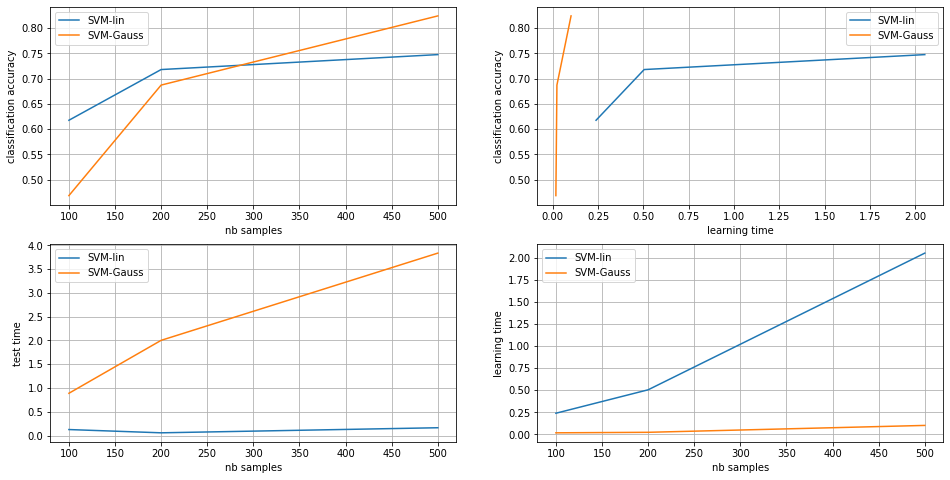

In [11]:
run_exp_nbex(nb_train_list=[100, 200, 500],      # sizes of the training set to be tested
             algs=[linear_svm, kernel_svm],      # algorithms to be tested
             labels=['SVM-lin', 'SVM-Gauss'])    # labels corresponding to tested algorithms

 Comme dit à la question précedente pour les tests le SVM-Gaussien est de complexité $O(np)$ donc le temps augmente avec $n$ alors que SVM-lin est de complexité $O(p)$ donc n'augmente pas quand $n$ augmente

/home/jay_boo/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


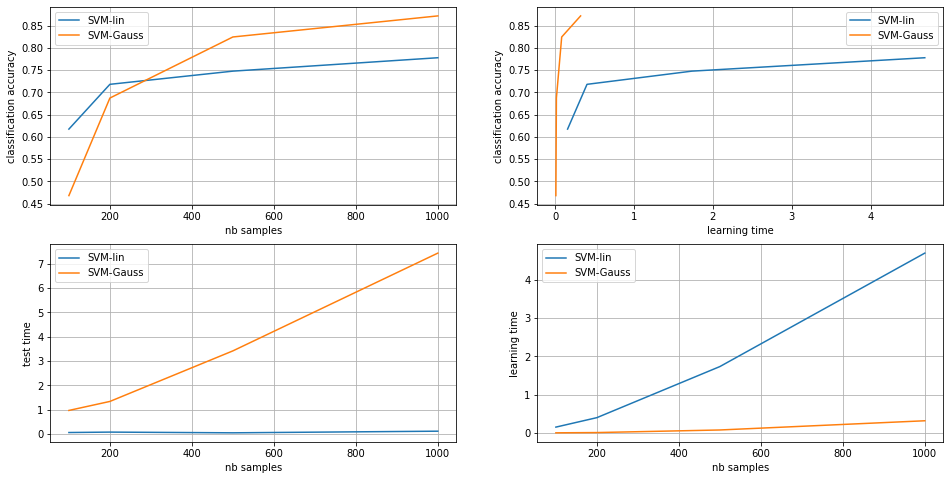

In [12]:
# TODO: What's the impact when the training dataset increases
# (you may go up to 50,000 examples, but it may induced HUGE computation time)
run_exp_nbex(nb_train_list=[100, 200, 500, 1000],      # sizes of the training set to be tested
             algs=[linear_svm, kernel_svm],      # algorithms to be tested
             labels=['SVM-lin', 'SVM-Gauss'])    # labels corresponding to tested algorithms

 On a donc à partir de $n = 100$ un meilleur model avec SVM-Gaus. Comme dit à la question précedente pour les test le SVM-Gaus est de complexité $O(np)$ donc le temps augmente avec $n$ alors que SVM-lin est de complexité $O(p)$ donc n'augmente pas quand $n$ augmente. Pour le learning time le SVM-lin augmente beaucoup plus que celui de SVM-Gauss 

# C. Low-rank kernel approximations 

In this part, we consider two methods ("Nyström" and "Rahimi-Recht") to approximate the kernel used in the SVM classification problem. 

`TODO` Let $\mathbf{K}\in\mathbb{R}^{n \times n}$ be the kernel Gram matrix appearing in the original SVM problem.  If we approximate $\mathbf{K}$ by $\hat{\mathbf{K}}=\mathbf{Z}\mathbf{Z}^T$ for some full-rank matrix $\mathbf{Z}\in\mathbb{R}^{n \times r}$, write the $r$-dimensional optimization problem one can obtain in this case: 

 [from equation (1)](#eqSVM) we get:
 
$$\hat{\alpha} \in argmin_{\alpha \in \mathbb{R}^n} 1^T [1-y\odot K \alpha]_+ + \lambda \alpha^T  K \alpha$$
 Assume $\boldsymbol{K}=\boldsymbol{Z} \boldsymbol{Z}^{\mathrm{T}}$ for some full-rank matrix $Z \in \mathbb{R}^{n \times r}$ with $r \leq n$.
We have the following predictor 
$$
\hat{h(x)}= Sign(\sum_{i=1}^n<\phi(x),\phi(x_i)>_\mathbb{H} \hat{\alpha_i})=Sign(\sum_{i=1}^n k(x,x_i) \hat{\alpha_i})
$$
 Let $\gamma=\boldsymbol{Z}^{\mathrm{T}} \boldsymbol{\alpha} \in \mathbb{R}^r$. 

Then the problem becomes
$$
\begin{array}{l}
\hat{\gamma} \in \underset{\gamma \in \mathbb{R}^r}{\operatorname{argmin}} 1^{\mathrm{T}}[1-\boldsymbol{y} \odot \boldsymbol{Z} \boldsymbol{\gamma}]_{+}+\lambda\|\boldsymbol{\gamma}\|_2^2 . \\
\hat{\boldsymbol{\alpha}}=\boldsymbol{Z}\left(\boldsymbol{Z}^{\mathrm{T}} \boldsymbol{Z}\right)^{-1} \boldsymbol{\hat{\gamma}}.
\end{array}
$$

with
$$
\begin{equation}
\boldsymbol{Z}=\left[\begin{array}{c}
\hat{\phi}\left(\boldsymbol{x}_1\right)^{\mathrm{T}} \\
\vdots \\
\hat{\phi}\left(\boldsymbol{x}_n\right)^{\mathrm{T}}
\end{array}\right] \in \mathbb{R}^{n \times r}
\end{equation}
$$


## C.1 "Nyström" approximation

The Nyström approximation is already implemented in Scikit-learn and you are not asked to re-implement it. Nevertheless, your are required to answer the following questions:

`TODO`

1) What is the expression of matrix $\mathbf{Z}$ in the Nyström approximation? 
 On utilise l'approximation de K suivante :  
$$
K \approx <P_B(\phi),P_B(\phi)>_\mathbb{H}= ZZ^T
$$
Que l'on réecrit : 
$$
<\phi,B>_\mathbb{H} (<B,B>_{\mathbb{H}})^{-1}<B,\phi>_\mathbb{H}=ZZ^T
$$
 En utilisant le décomposition SVD suivante $<B,B>_\mathbb{H}=V\Sigma^2 V^T$ on,  déduit l'expression de $Z$ suivante:
$$
Z= <B,\phi>_\mathbb{H} V\Sigma^{-1}
$$
 En utilisant les notations suivantes : $S \subset \{  1,...,n\}$ avec $card(S)=r$
On note $\phi_S$ les colonnes de $\phi=[\phi(x_1),\phi(x_2)...\phi(x_n)]\in \mathbb{H}^n$ indexé par $S$. Alors on fixe $B=\phi_S$.
 On en déduit une expression simplifiante de $<B,\phi>_\mathbb{H}=<\phi_S,\phi>_\mathbb{H}$ car il correspond aux $r$ colonnes de la matrice $K$ non calculée.
On note $K_S$ ces $r$ colonnes de $K$ indéxées par $S$.
$$
Z=\left(K_{\mathcal{S}}\right)^{\mathrm{T}} \mathrm{V} \Sigma^{-1}
$$
Avec:

$\mathrm{V}=$ la matrice  des vecteurs propres de  $<B,B>_\mathbb{H}=<\phi_S,\phi_S>_\mathbb{H}=K_{S,S}$

$\Sigma=$ la matrice diagonales des valeurs propres de  $K_{S,S}$.

 &rarr; Ainsi on approxime $K$ a partir d'un sous ensemble $K_S$

2) What are the operations performed by the methods "fit" and "transform" of the class "Nystroem"? (see code below and Scikit-learn documentation)

- Fit :Tire $S$ de cardinal $n\_components$, calcul $K_S$  et son svd associé  pour obtenir $V$ et $\Sigma^{-1}$

- Transform : Applique les nouvelles features map calculées dans le $fit()$
$$
\begin{equation}
\boldsymbol{Z}=\left[\begin{array}{c}
\hat{\phi}\left(\boldsymbol{x}_1\right)^{\mathrm{T}} \\
\vdots \\
\hat{\phi}\left(\boldsymbol{x}_n\right)^{\mathrm{T}}
\end{array}\right] \in \mathbb{R}^{n \times r}
\end{equation}
$$
et retourne le $Z\in \mathbb{R}^{n\times r}$

3) Run the code below and discuss the results.


In [13]:
data_test.shape

(10000, 784)

200 examples of dimension 100
DescribeResult(nobs=40000, minmax=(-0.03727502574487668, 0.991588764554396), mean=0.0017237396239808537, variance=0.000497123519722116, skewness=22.527676087156788, kurtosis=663.5115979354663)


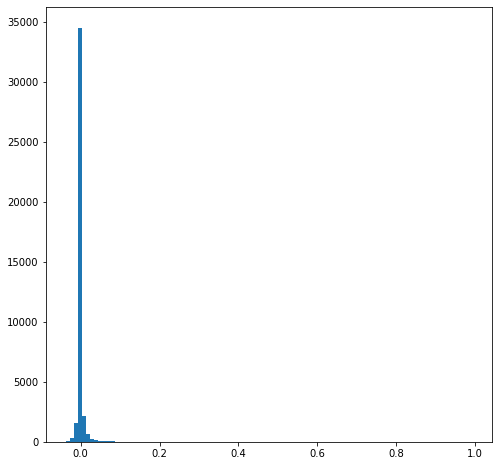

In [14]:
nystroem = Nystroem(gamma=0.001)
nystroem.set_params(n_components=100)

sub_data = data_train[:200]

# compute the parameters required to generate the new feature space
nystroem.fit(sub_data)

# generation of new features
sub_data_tilde = nystroem.transform(sub_data)
print(f'{sub_data_tilde.shape[0]} examples of dimension {sub_data_tilde.shape[1]}')

# approximation quality
K = rbf_kernel(sub_data, gamma=0.001)
K_tilde = sub_data_tilde @ sub_data_tilde.transpose()
print(describe((K-K_tilde).flatten()))
plt.figure(figsize=(8, 8))
plt.hist((K-K_tilde).flatten(), bins=100)
plt.show()

La distribution est fortement centré sur 0 avec beaucoup d'individus en 0 car il s'agit de tout les element qui on bin été prédis cra comme on est dans un classifier l'erreur est de 0 si bien prédis.

Il est possible qu'il y ai au moins 1 point avec une grande erreur sinon on aurait un graphique centré sur le 0. Les $x_1$ jusqua $x_r$ indéxé par $S$ que l'on à pris étaient pas mal pour quasi tout les points sauf pour 1 ou 2 points avec une grande erreur.

## C.2 "Rahimi-Recht" approximation

In this part, we consider the "Rahimi-Recht" approximation, also often referred to as "Random Fourier features". You are asked to implement this method. Please asnwer the following questions: 

`TODO`

1) To what kind of kernel does the Rahimi-Recht approximation apply?

Les noyeaux qui pouvant s'écrire sous la forme : $K\left(x, x^{\prime}\right)=f\left(x-x^{\prime}\right)$

Le noyau doit etre invariante par translation. 

Cette condition est nécessaire pour pouvoir utiliser le représentation de Bochner au cours de l'approximation.

2) What is the expression of matrix $\mathbf{Z}$ in the Rahimi-Recht approximation? 
Grace à la représentation de Bochner on peut écrire :

$$
k(x,x')=\int_{\mathbb{R}^p} cos(w^T(x-x'))d\mu(w)k(x,x')
$$
Que l'on approxime par 
$$
k(x,x') \approx \frac{1}{r}\sum_{j=1}^r cos(w_j^T(x-x'))
$$
En écrivant $K$ sous la forme $K=ZZ^T$ on a donc l'approximation de K utilisant la matrice $Z$ suivante:

$$
Z=\frac{1}{\sqrt{r}}\left(\begin{array}{ccccc}
\cos \left(\omega_1^{\top} \boldsymbol{x}_1\right) & \sin \left(\omega_1^{\top} \boldsymbol{x}_1\right) & \ldots & \cos \left(\omega_r^{\top} \boldsymbol{x}_1\right) & \sin \left(\omega_r^{\top} \boldsymbol{x}_1\right) \\
\vdots & \vdots & & \vdots & \vdots \\
\cos \left(\omega_1^{\top} \boldsymbol{x}_n\right) & \sin \left(\omega_1^{\top} \boldsymbol{x}_n\right) & \ldots & \cos \left(\omega_r^{\top} \boldsymbol{x}_n\right) & \sin \left(\omega_r^{\top} \boldsymbol{x}_n\right)
\end{array}\right)
$$
 Ainsi on calcul les nouvelles features map suivantes :
$$
\hat{\phi}(\boldsymbol{x})=\frac{1}{\sqrt{r}}\left[\begin{array}{c}
\cos \left(\omega_1^{\mathrm{T}} \boldsymbol{x}+b_1\right) \\
\sin \left(\omega_1^{\mathrm{T}} \boldsymbol{x}+b_1\right) \\
\vdots \\
\cos \left(\omega_r^{\mathrm{T}} \boldsymbol{x}+b_r\right) \\
\sin \left(\boldsymbol{\omega}_r^{\mathrm{T}} \boldsymbol{x}+b_r\right)
\end{array}\right]
$$
 Avec les $\forall j \in \{ 1, ...r\}$ $b_j=0$ 

**Important: $Z \in \mathbb{R}^{n\times 2r}$**

3) If the considered kernel is $\kappa(\mathbf{x}_i, \mathbf{x}_j) = \exp(-\gamma\| \mathbf{x}_i-\mathbf{x}_j\|^2_2)$, what is the distribution of the "pulsations" appearing in the Rahimi-Recht approximation? 

Une distribution gaussienne centrée avec une variance de ${2\gamma}$

&rarr; Lors du calcul des nouvelles features map $z(x)$ on projette $x$ dans une direction aléatoire $w$ tiré à partir de la transformé de fourrier du kernel choisi.

Autrement dit, en choisisant 
\begin{equation}
k(\Delta)= e^{-\gamma||\Delta||^2}
\end{equation}
On applique la transformée de Fourrier:
\begin{equation}
p(w)=\frac{1}{2\pi} \int e^{-iw\delta} k(\delta) d\Delta
\end{equation}

Dans notre cas la transformée de fourrier donne une gaussienne centrée de variance $2\gamma$

4) Implement and test the functions `draw_direction()` and `transform_data()` below.

5) Run the code in the third cell and discuss the quality of the obtained approximation.  

In [13]:
def draw_directions(n_features, n_components=100, gamma=1.):
    """ Draw the random directions used to transform the data.
    
    Parameters
    ----------
    n_features : int
        Number features in the original space.
    n_components : int, default=100
        Number of Monte Carlo samples per original feature.
        Equals the dimensionality of the computed feature space.
        Has to be even.
    gamma : float, default=1.0
        Parameter of RBF kernel: exp(-gamma * x^2)
    Returns
    -------
    W : array-like, shape (n_components/2, n_features)
        D directions, où D = n_features/2.
    """
    # We apply fourrier transform over gaussian kernel which is :
    weights = (2.0 * gamma) ** 0.5 * np.random.normal(
            size=(n_features, n_components)
        )
    return weights.T[:int(n_components/2),:]

In [14]:
def transform_data(X, W):
    """Transform the dataset.
    
    Parameters
    ----------
    X : {array-like, sparse matrix}, shape (n_samples, n_features)
        Data, where n_samples in the number of samples
        and n_features is the number of features.
    W : array-like, shape (n_components/2, n_features)
        Directions to build the new features.
    Returns
    -------
    Z : array-like, shape (n_samples, n_components)
    """
    r=W.shape[0] # We used r=2* W.shape[0] in MC approximation 
    W_bis=np.concatenate((W,W),axis=0)
    r=W_bis.shape[0]
    projection=np.dot(X,W_bis.T) 
    # 2r=n_components/2
    np.cos(projection,projection)
    
    
    projection*= (1/r)**0.5 
    return projection

200 examples of dimension 100
DescribeResult(nobs=40000, minmax=(-0.25225130391641853, 0.6055448925175182), mean=0.0035569295499994864, variance=0.0077940740015632745, skewness=0.5817086044126688, kurtosis=2.099908131263759)


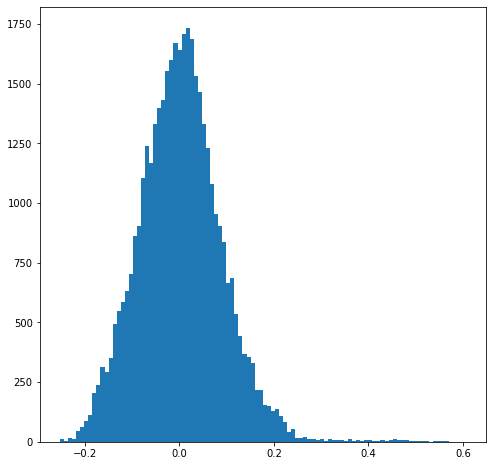

In [17]:
sub_data = data_train[:200]
n_features = data_train.shape[1]

# draw directions
directions = draw_directions(n_features, n_components=100, gamma=0.001)

# generate the new features
sub_data_tilde = transform_data(sub_data, directions)
print(f'{sub_data_tilde.shape[0]} examples of dimension {sub_data_tilde.shape[1]}')

# quality of the approximation
K = rbf_kernel(sub_data, gamma=0.001)
K_tilde = sub_data_tilde @ sub_data_tilde.transpose()
print(describe((K-K_tilde).flatten()))
plt.figure(figsize=(8, 8))
plt.hist((K-K_tilde).flatten(), bins=100)
plt.show()

## C.3 Comparison of "Nyström" and "Rahimi-Recht" approximations

At this point, you may want to have a look at the definition of the function "run_exp_approx" above.

`TODO` Run the cell below and comment the results of the comparison.


[[134.15274143434573, 53.00900754552182, 37.78743525375542, 32.36229072504458, 16.464758040105643, 10.754925201749707], [412.43512637916314, 207.41136042358656, 162.4687050475433, 143.3950769536821, 114.57661307763293, 107.58383829124926, 101.75378339288218, 100.91573423369762]]


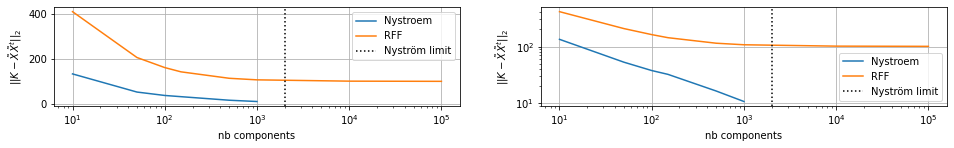

In [18]:
class transform_rff_0_001:
    def __init__(self) -> None:
        pass
    def set_params(self,n_components):
        self.n_components=n_components
    def fit_transform(self,X):
        return transform_data(X, draw_directions(X.shape[1], n_components=self.n_components, gamma=0.001))
sub_data = data_train[:2000]
run_exp_approx(data_train=sub_data,                                        # data
               approx_sizes=[10, 50, 100, 150, 500, 1000, 10**4, 10**5],   # sizes of approximation to be tested
               algs=[Nystroem(gamma=0.001),transform_rff_0_001() ],          # methods to be tested (Nystroem object or function to transform the data)
               labels=['Nystroem', 'RFF'])                                 # label to attach to each method

&rarr;Le fait que avec le RFF on converge est du au fait que notre estimation de MC converge.
Lors de cette approximation on utilise un echantillon de $n\_components$ afin d'utiliser une approximation de MonteCarlo de la représentation de Bochner's.*($k(\Delta) =\int_\mathbb{R^p} cos(w^T \Delta) d\mu(w)$)*

\begin{equation}
k(\Delta) \approx \frac{1}{r} \sum_{j=1}^{r} cos(w_j^T \Delta) d\mu(w)
\end{equation}

Ainsi à partir d'une certaine taille d'echantillon $R$ pour effectué cette approximation , l'ajout de nouveaux points dans cet echantillon n'a que très peu d'impact sur notre approximation et donc sur la qualité de notre approximation

***

&rarr;Pour Nystrom  la convergence de $||K - \hat{X}\hat{X}^T||$ peut s'expliquer par la structure des données

Est ce que on a beaucoup de points proches? ou à l'inverse tout les points sont très éloignés.
Si tous les points de nos données sont proches comme ca semble etre le cas d'après ce qu'on a vu précedmment alors l'approximation  s 'affine de moins en moins. 



Passage de $S_{n_{component}}$ à $S_{n_{component}+1}$*(Le sous ensemble de points servant à la mise en place de l'approximation de $K$)*.

Plus on a $n\_component$ élevé plus il est probable que  lors de l'ajout d'un nouveau point $x$ dans le sous ensemble $S_{n_{component}}$.  il y est d'hors et déjà un point  très similaire  au sein de $S_{n_{component}}$.


la différence des deux évolutions de ces deux techniques d'approximation de $K$ traduit bien la difference d'idée entre les deux processus : L'une utilise un nombre de points de nos données restreint afin d'approximer K. De ce fait elle est très satisfaisante pour faire des approximations de $K$ spécifique à cet ensemble de point.  Tandis que l'approximation de Rahimi-Recht sera meilleur pour une approximation générale de K en utilisant une approximation de Monte Carlo. 

On rappel que seul l'évolution de l'approximation de Nystrom depend des données. Ainsi la différence globale entre les évolutions respectives de $||K - \hat{X}\hat{X}^T||$ s'explique uniquement par une structure de données en faveur de l'approximation de Nystrom *(Voir partie C.1)*

***

# D. SVM classification with approximate kernels

In this part of the practical session, we study how the "Nyström" and "Rahimi-Recht" low-rank approximations impact the accuracy and the learning/testing times of the classification procedures. 

To start, write down how the classification decision is made when considering:


 On rappel dans un premier temps le contexte dans lequel on se trouve :
**Contexte**

$\hat{h}(x) =Sign(\sum_{i=1}^n<\phi(x),\phi(x_i)> \hat{\alpha_i})$


$\hat{h}(x) =Sign(\sum_{i=1}^n  k(x,x_i)\hat{\alpha_i})$

$\hat{h}(x) =Sign(\sum_{i=1}^n  k(x,x_i)\hat{\alpha_i})$
$\hat{h}(x) =Sign(\hat{\gamma}^T z(x))$ avec $\hat{\gamma}$ de taille $\mathbb{R}^r$ issue du problème d'optimisation ci dessous et $Z$ de taille $\mathbb{R}^{n \times r}$

$\hat{\gamma} \in argmin_{\gamma \in \mathbb{R}^r } 1^T [1-y \odot Z \gamma]_+ +\lambda ||\gamma||^2_2$

Adopté une de ces méthodes d'approximation c'est adopté une forme d'approximation de la matrice $Z$ au cours du problème d'optimisation ci dessus.

**A) Nystrom approximation**

On utilise l'expression de Z suivante

$$
Z=\left(K_{\mathcal{S}}\right)^{\mathrm{T}} \mathrm{V} \Sigma^{-1}
$$


de taille $\mathbb{R}^{n \times r}$


**B) Rahimi Recht approximation**

La taille de $\gamma$ et $Z$ diverge.
On utilise dans la formulation précedente 

$z(x)=\frac{1}{\sqrt{r}} [cos(w_1^T x) sin(w_1^T x) ... cos(w_r^T x)]^T $
de taille $2r$
avec $\gamma =Z^T \alpha$ de taille $\mathbb{R}^{2r}$



$$
Z=\frac{1}{\sqrt{r}}\left(\begin{array}{ccccc}
\cos \left(\omega_1^{\top} \boldsymbol{x}_1\right) & \sin \left(\omega_1^{\top} \boldsymbol{x}_1\right) & \ldots & \cos \left(\omega_r^{\top} \boldsymbol{x}_1\right) & \sin \left(\omega_r^{\top} \boldsymbol{X}_1\right) \\
\vdots & \vdots & & \vdots & \vdots \\
\cos \left(\omega_1^{\top} \boldsymbol{x}_n\right) & \sin \left(\omega_1^{\top} \boldsymbol{x}_n\right) & \ldots & \cos \left(\omega_r^{\top} \boldsymbol{x}_n\right) & \sin \left(\omega_r^{\top} \boldsymbol{x}_n\right)
\end{array}\right)
$$

## D.1 Embedding the approximations into Scikit-learn functions

Before proceedings to any comparison, we first need to embed our kernel low-rank approximation in the standard tools for linear SVM classification implemented by Scikit-learn. From your answer to the previous questions, you should have come up to the following conclusions: SVM with kernel approximation is equivalent to

* First, transform the original feature $\mathbf{x}\in\mathbb{R}^p$ into another "feature" $\mathbf{z}\in\mathbb{R}^r$ (e.g., matrix $\mathbf{X}\in \mathbb{R}^{n \times p}$ becomes $\mathbf{Z}\in \mathbb{R}^{n \times r}$)
* Second, apply standard linear regression on the transformed features. 

These two operations can be embedded into a single function thanks the Scikit-learn class "Pipeline". 
An example of use of "Pipeline" to implement SVM classification with Nyström approximation of the Gaussian kernel is provided in the next cell.

`TODO` Consult the documention of Scikit-learn to understand how the class Pipeline proceeds. 


In [17]:
nystroem_approx_svm = Pipeline([("feature_map", Nystroem(gamma=0.001)),
                                ("svm", svm.LinearSVC())])


nystroem_approx_svm[0].set_params(n_components=100)
test_classifier(nystroem_approx_svm, 500)

nystroem_approx_svm[0].set_params(n_components=400)
test_classifier(nystroem_approx_svm, 500)

nystroem_approx_svm[0].set_params(n_components=1000)
test_classifier(nystroem_approx_svm, 500)        # !!! warning: nb_feat has to be smaller than nb_ex

------ nb_train : 500 ------
learning time: 0.17s
testing time:  0.18s
accuracy: 0.7984

------ nb_train : 500 ------
learning time: 0.37s
testing time:   0.5s
accuracy: 0.8295



/home/ensai/.local/lib/python3.8/site-packages/sklearn/kernel_approximation.py:1001: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(


------ nb_train : 500 ------
learning time: 0.52s
testing time:  0.48s
accuracy: 0.8334



To apply the same approach for the Rahimi-Recht approximation, we must create a class (say `RFF_transform`) with methods "fit" and "transform" for this approximation. 

`TODO` Complete the definition of the class `RFF_transform` below and then (in the second cell) define a new object `rff_approx_svm` concatenating the Rahimi-Recht approximation and the linear SVM classification with a code similar to

```python
mod = Pipeline([("feature_map", RFF_transform(gamma=0.001, n_components=10**3)),
                        ("svm", svm.LinearSVC())])
```


In [15]:
class RFF_transform(TransformerMixin, BaseEstimator):
    """Approximates feature map of an RBF kernel by Monte Carlo approximation
    of its Fourier transform.
    It implements Random Fourrier Features.
    
    Parameters
    ----------
    gamma : float, default=1.0
        Parameter of RBF kernel: exp(-gamma * x^2)
    n_components : int, default=100
        Number of Monte Carlo samples per original feature.
        Equals the dimensionality of the computed feature space.
    Attributes
    ----------
    random_offset_ : ndarray of shape (n_components,), dtype=float64
        Random offset used to compute the projection in the `n_components`
        dimensions of the feature space.
    random_weights_ : ndarray of shape (n_features, n_components),\
        dtype=float64
        Random projection directions drawn from the Fourier transform
        of the RBF kernel.
    """
    def __init__(self, *, gamma=1., n_components=100):
        self.gamma = gamma
        self.n_components = n_components

    def fit(self, X, y=None):
        """Fit the model with X.
        Samples random projection according to n_features.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where n_samples in the number of samples
            and n_features is the number of features.
        Returns
        -------
        self : object
            Returns the transformer.
        """

        n_features = X.shape[1]
        self.random_directions_ = draw_directions(n_features, self.n_components, self.gamma)
        return self

    def transform(self, X):
        """Apply the approximate feature map to X.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            New data, where n_samples in the number of samples
            and n_features is the number of features.
        Returns
        -------
        X_new : array-like, shape (n_samples, n_components)
        """
        return transform_data(X, self.random_directions_)

In [16]:
# TODO: same test as for Nyström but with Rahimi-Recht approximation
rff_approx_svm =Pipeline([("feature_map", RFF_transform(gamma=0.001)),
                                ("svm", svm.LinearSVC())])




rff_approx_svm[0].set_params(n_components=100)
test_classifier(rff_approx_svm, 500)

rff_approx_svm[0].set_params(n_components=400)
test_classifier(rff_approx_svm, 500)

rff_approx_svm[0].set_params(n_components=1000)
test_classifier(rff_approx_svm, 500)        # !!! warning: nb_feat has to be smaller than nb_ex

------ nb_train : 500 ------
learning time: 0.091s
testing time:  0.13s
accuracy: 0.4586

------ nb_train : 500 ------
learning time: 0.23s
testing time:  0.25s
accuracy: 0.6246

------ nb_train : 500 ------
learning time: 0.65s
testing time:  0.45s
accuracy: 0.72



In [22]:
#DELETE



mod = Pipeline([("feature_map", RBFSampler(gamma=0.001)),
                         ("svm", svm.LinearSVC())])

mod[0].set_params(n_components=100)
test_classifier(mod, 500)

mod[0].set_params(n_components=400)
test_classifier(mod, 500)

mod[0].set_params(n_components=1000)
test_classifier(mod, 500)        # !!! warning: nb_feat has to be smaller than nb_ex

------ nb_train : 500 ------
learning time: 0.19s
testing time:  0.15s
accuracy: 0.6883

------ nb_train : 500 ------
learning time: 0.29s
testing time:  0.22s
accuracy: 0.7939

------ nb_train : 500 ------
learning time: 0.62s
testing time:   0.5s
accuracy: 0.814



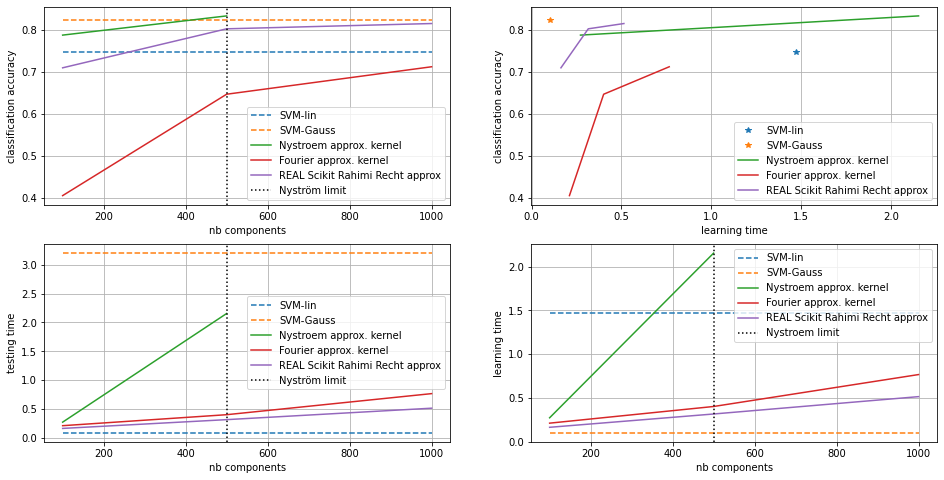

In [23]:

run_exp_svm_approx(500,                              # size of the training set
                   algs=[linear_svm, kernel_svm,     # algorithms to be compared
                         nystroem_approx_svm,
                         rff_approx_svm,mod],
                   labels=['SVM-lin', 'SVM-Gauss',   # label to attach to each algorithm
                           'Nystroem approx. kernel',
                           'Fourier approx. kernel',"REAL Scikit Rahimi Recht approx"], 
                   nb_feat_list=[100, 500, 1000]     # sizes of approximation to be tested (for approximation-based algorithms)
                  )

## D.2 Comparison of the approximations in terms of accuracy and learning/testing times

`TODO` Run the two following celles and discuss the results. 

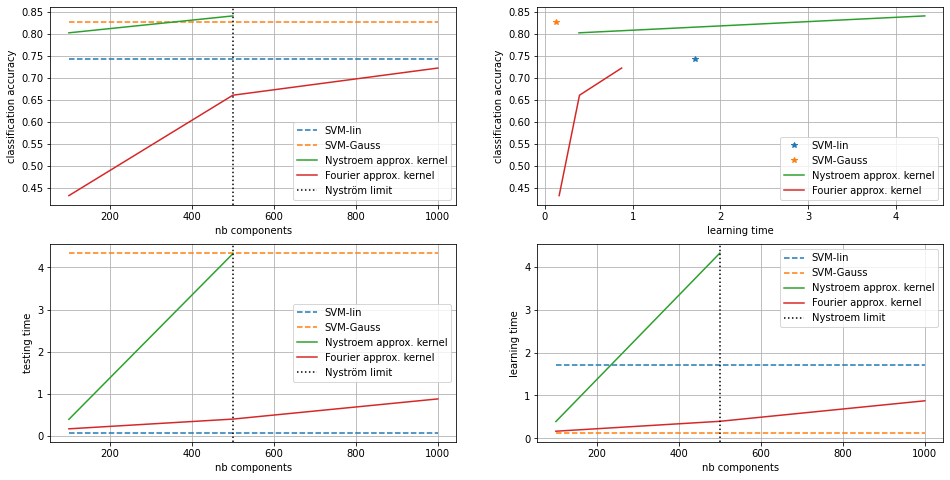

In [21]:
run_exp_svm_approx(500,                              # size of the training set
                   algs=[linear_svm, kernel_svm,     # algorithms to be compared
                         nystroem_approx_svm,
                         rff_approx_svm],
                   labels=['SVM-lin', 'SVM-Gauss',   # label to attach to each algorithm
                           'Nystroem approx. kernel',
                           'Fourier approx. kernel'], 
                   nb_feat_list=[100, 500, 1000]     # sizes of approximation to be tested (for approximation-based algorithms)
                  )


**Rahimi Recht  Approximation *(courbe rouge)***
Lors de l'utilisationde l'approxiamtion de Rahimi-Recht on observe que nos prédictions s'améliore dès lors qu'on utilise un nombre suffisant de sample lors de l'approximation de Monte Carlo. Cependant un nombre accru de sample de MonteCarlo implique une augmentation du testing et learning time

Dans la suite on note $r=n\_components$ ainsi que $c$ la complexité de calcul pour obtenir $\alpha$ sans le cout de l'évaluation de $Z$

En effet on a pour cet approximation

- Compléxité d'entrainement pour evaluer $Z$ : $O(prn)$

Ainsi au global on a :
- learning complexity: $O(c+prn)$
- testing complexity : $O(pr)$


**Nystroem Approximation *(courbe verte)***

Avec l'approximation de Nystrom la complexité pour evaluer $Z$ est similaire à la compléxité d'evaluation de $Z$ lors de l'approximation de Rahimi-Recht càd : $O(prn)$
Cependant la complexité de test tombe à $O(pn)$
- learning complexity: $O(c+prn)$
- testing complexity : $O(pn)$

**SVM lin et SVM Gauss**

 Enfin on peut rappeler les compléxités de test et d'apprentissage des SVM à kernel gaussien et du SVM linéaire :


| SVM type      | Testing complexity | 
| ----------- | ----------- | 
| SVM lin      |  $O(p)$      |
| SVM Gauss   | $O(np)$        |
 
 On retrouve bien sur nos graphiques que le testing time depend de $n\_components$  noté $r$ ci dessus lorsque l'on utilise l'approximation de Rahimi-Recht tandis que pour l'approximation de Nystrom le testing time ne depend que de $n$ et $p$
 
 Pour le learning time on retrouve bien graphiquement que les deux approches d'approximation sont similaires $O(c+prn)$. Ca depend de $p$, $n\_components$ et $n$.


 Le fait que la precision de notre classification s'ameliore avec $n\_components$ est logique car notre approximation de $K$ s'améliore avec $n\_components$**(voir graphiques en C3)**.Le fait que la precision pour le cas Nystrom  commence à $0.8$ s'explique par la structure des données très favorable : Très peux hétérogénéité dans les données




| SVM kernel Approximation      | Testing complexity | Learning complexity 
| ----------- | ----------- | ----------- | 
| Rahimi-Recht      |  $O(pr)$      |$O(c+prn)$|
| Nyström | $O(pn)$        |$O(c+prn)$|


In [ ]:
# TODO : increase the size of the training set and of the approximation space
run_exp_svm_approx(5000,                                   # size of the training set
                   algs=[linear_svm, kernel_svm,           # algorithms to be compared
                         nystroem_approx_svm,
                         rff_approx_svm],
                   labels=['SVM-lin', 'SVM-Gauss',         # label to attach to each algorithm
                           'Nystroem approx. kernel',
                           'Fourier approx. kernel'], 
                   nb_feat_list=[100, 10**3, 10**4, 10**5] # sizes of approximation to be tested (for approximation-based algorithms)
                  )

## D.3 Scaling property of the approximate SVM classification procedures

In this part of the practical session, you will test different classification procedures and study how they compare in terms of accuracy, learning time and testing time.

`TODO`: Run the following cells and discuss the results. 

### SVM with Gaussian kernel

In [22]:
test_classifier(kernel_svm, 1000)

------ nb_train : 1000 ------
learning time: 0.29s
testing time:   6.2s
accuracy: 0.8722



In [23]:
test_classifier(kernel_svm, 5000)

------ nb_train : 5000 ------
learning time:  4.6s
testing time:  2.7e+01s
accuracy: 0.9233



In [24]:
test_classifier(kernel_svm, 20000)

------ nb_train : 20000 ------
learning time: 7.3e+01s
testing time:  7.4e+01s
accuracy: 0.9482



In [25]:
test_classifier(kernel_svm, 50000)

 On observe une forte augmentation du testing time, en effet comme la complexité est de $O(np)$  et donc dépend bien de n. Pour le learning time il augmente aussi car la complexité est aussi de $O(np)$  

### Linear SVM

In [18]:
mod = svm.LinearSVC()
test_classifier(mod, 5000)
print(f'early stopping after {mod.n_iter_} iteration while max_iter={mod.max_iter}')

------ nb_train : 5000 ------
learning time: 1.2e+01s
testing time:  0.057s
accuracy: 0.8196

early stopping after 1000 iteration while max_iter=1000


/home/ensai/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [19]:
mod = svm.LinearSVC()
test_classifier(mod, 20000)
print(f'early stopping after {mod.n_iter_} iteration while max_iter={mod.max_iter}')

------ nb_train : 20000 ------
learning time: 1.1e+02s
testing time:  0.058s
accuracy: 0.8831

early stopping after 1000 iteration while max_iter=1000


/home/ensai/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
mod = svm.LinearSVC()
test_classifier(mod, 50000)
print(f'early stopping after {mod.n_iter_} iteration while max_iter={mod.max_iter}')

 Ici les testing time est learning time n'augmente pas avec n, en effet pour un linear SVM la complexité dépend seulement des feature ($O(p)$ )

### SVM with Gaussian kernel and Rahimi-Recht approximation

#### 5 000 examples 

In [21]:
mod = Pipeline([("feature_map", RBFSampler(gamma=0.001, n_components=10**3)),
                         ("svm", svm.LinearSVC())])
test_classifier(mod, 5000)

------ nb_train : 5000 ------
learning time:  2.3s
testing time:  0.57s
accuracy: 0.8951



In [22]:
mod = Pipeline([("feature_map", RBFSampler(gamma=0.001, n_components=10**4)),
                         ("svm", svm.LinearSVC())])
test_classifier(mod, 5000)

------ nb_train : 5000 ------
learning time: 2.1e+01s
testing time:   5.8s
accuracy: 0.9233



 Ici on a augmenté r (nb_component) et comme la complexité du learning et testing de Rahimi-Recht  dépendent de r ($O(pr)$      et $O(c+prn)$) on retrouve bien une augmentation dans les testing et learning time

In [23]:
# What are the results if we use SGD to optimize the parameter of the linear SVM?
mod = Pipeline([("feature_map", RBFSampler(gamma=0.001, n_components=10**4)),
                         ("svm", SGDClassifier(early_stopping=True))])
test_classifier(mod, 5000)

------ nb_train : 5000 ------
learning time: 1.4e+01s
testing time:   4.7s
accuracy: 0.9068



#### 20 000 examples 

In [24]:
mod = Pipeline([("feature_map", RBFSampler(gamma=0.001, n_components=10**3)),
                         ("svm", svm.LinearSVC())])
test_classifier(mod, 20000)

------ nb_train : 20000 ------
learning time:  8.7s
testing time:  0.59s
accuracy: 0.9204



In [25]:
mod = Pipeline([("feature_map", RBFSampler(gamma=0.001, n_components=10**4)),
                         ("svm", svm.LinearSVC())])
test_classifier(mod, 20000)

------ nb_train : 20000 ------
learning time: 7.3e+01s
testing time:   4.7s
accuracy: 0.9498



 Ici on a augmenté r (nb_component) et comme la complexité du learning et testing de Rahimi-Recht  dépendent de r ($O(pr)$      et $O(c+prn)$) on retrouve bien une augmentation dans les testing et learning time

 On remarque aussi que comme on a changé n le learning time a augmenté alors que le testing time est inchangé. En effet n est présent suelement dans la compléxité du learning time ($O(c+prn)$)

In [26]:
# What are the results if we use SGD to optimize the parameter of the linear SVM?
mod = Pipeline([("feature_map", RBFSampler(gamma=0.001, n_components=10**4)),
                         ("svm", SGDClassifier(early_stopping=True))])
test_classifier(mod, 20000)

------ nb_train : 20000 ------
learning time: 4.1e+01s
testing time:   4.9s
accuracy: 0.9243



 Utiliser le SGB nous permet de gagner du temp en apprentissage cependant on à une pertre d'accuracy sur nos résultats 

#### 50 000 examples 

In [27]:
mod = Pipeline([("feature_map", RBFSampler(gamma=0.001, n_components=10**3)),
                         ("svm", svm.LinearSVC())])
test_classifier(mod, 50000)

------ nb_train : 50000 ------
learning time: 2e+01s
testing time:   0.6s
accuracy: 0.9292



In [28]:
mod = Pipeline([("feature_map", RBFSampler(gamma=0.001, n_components=10**4)),
                         ("svm", svm.LinearSVC())])
test_classifier(mod, 50000)

------ nb_train : 50000 ------
learning time: 1.7e+02s
testing time:   5.1s
accuracy: 0.9614



 Ici on a augmenté r (nb_component) et comme la complexité du learning et testing de Rahimi-Recht  dépendent de r ($O(pr)$      et $O(c+prn)$) on retrouve bien une augmentation dans les testing et learning time

 On remarque aussi que comme on a encore augmenté n le learning time a encore augmenté alors que le testing time est inchangé. En effet n est présent seulement dans la compléxité du learning time ($O(c+prn)$)

In [29]:
# What are the results if we use SGD to optimize the parameter of the linear SVM?
mod = Pipeline([("feature_map", RBFSampler(gamma=0.001, n_components=10**4)),
                         ("svm", SGDClassifier(early_stopping=True))])
test_classifier(mod, 50000)

------ nb_train : 50000 ------
learning time: 8.9e+01s
testing time:   5.2s
accuracy: 0.9304



 Utiliser le SGB nous permet de gagner du temps en apprentissage cependant on à une perte d'accuracy sur nos résultats docn un modèle plus rapide à apprendre mais moins performant

### SVM with Gaussian kernel and Nyström approximation

#### 5 000 examples 

In [30]:
mod = Pipeline([("feature_map", Nystroem(gamma=0.001, n_components=10**3)),
                         ("svm", svm.LinearSVC())])
test_classifier(mod, 5000)

------ nb_train : 5000 ------
learning time:  5.0s
testing time:  0.92s
accuracy: 0.9103



#### 20 000 examples

In [31]:
mod = Pipeline([("feature_map", Nystroem(gamma=0.001, n_components=10**3)),
                         ("svm", svm.LinearSVC())])
test_classifier(mod, 20000)

------ nb_train : 20000 ------
learning time: 1.2e+01s
testing time:  0.71s
accuracy: 0.9362



In [32]:
mod = Pipeline([("feature_map", Nystroem(gamma=0.001, n_components=10**4)),
                         ("svm", svm.LinearSVC())])
test_classifier(mod, 20000)

------ nb_train : 20000 ------
learning time: 8.2e+02s
testing time:  2.5e+01s
accuracy: 0.9527



In [33]:
# What are the results if we use SGD to optimize the parameter of the linear SVM?
mod = Pipeline([("feature_map", Nystroem(gamma=0.001, n_components=10**4)),
                         ("svm", SGDClassifier(early_stopping=True))])
test_classifier(mod, 20000)

------ nb_train : 20000 ------
learning time: 7.7e+02s
testing time:  2.7e+01s
accuracy: 0.9252



 Utiliser le SGB nous permet de gagner du temps en apprentissage cependant on à une perte d'accuracy sur nos résultats docn un modèle plus rapide à apprendre mais moins performant

#### 50 000 examples

In [34]:
mod = Pipeline([("feature_map", Nystroem(gamma=0.001, n_components=10**3)),
                         ("svm", svm.LinearSVC())])
test_classifier(mod, 50000)

------ nb_train : 50000 ------
learning time: 2.3e+01s
testing time:  0.78s
accuracy: 0.9445



In [35]:
mod = Pipeline([("feature_map", Nystroem(gamma=0.001, n_components=10**4)),
                         ("svm", svm.LinearSVC())])
test_classifier(mod, 50000)

------ nb_train : 50000 ------
learning time: 1e+03s
testing time:  2.9e+01s
accuracy: 0.964



 On voit que quand n augmente le learning time augmente mais pas le testing time.

 Quand r augmente le learning time et le testing time augmente.

 Comme la complexité du learning time est de $O(c+prn)$ les resultats sont logique. Cependant pour le testing time la compléxité est de $O(pn)$ et aussi nos resultats nous donnerais plutot une complexité qui dépent de p et non de n.

In [36]:
# What are the results if we use SGD to optimize the parameter of the linear SVM?
mod = Pipeline([("feature_map", Nystroem(gamma=0.001, n_components=10**4)),
                         ("svm", SGDClassifier(early_stopping=True))])
test_classifier(mod, 50000)

------ nb_train : 50000 ------
learning time: 9.3e+02s
testing time:  2.8e+01s
accuracy: 0.9281



On peut donc resumer les compléxités en 1 tableaux :

|    | Testing complexity |  Learning complexity 
| ----------- | ----------- |  ----------- | 
| SVM lin      |  $O(p)$      | $O(p)$ 
| SVM Gauss   | $O(np)$        |$O(np)$  
| Rahimi-Recht      |  $O(pr)$      |$O(c+prn)$|
| Nyström | $O(pn)$        |$O(c+prn)$|